**Image Restoration** It is going to start with low resolution, poor quality JPEGs, with writing written over the top of them, and get them to replace them with high resolution, good quality pictures in which the text has been removed.

## Setting up enviroment

In [0]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [0]:
fastai.__version__

'1.0.60'

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

In order to create something which can turn crappy images into nice images, we needed dataset containing nice versions of images and crappy versions of the same images. The easiest way to do that is to start with some nice images and "crappify" them.

In [0]:
from crappify import *

In [0]:
from fastai.vision import *
from PIL import Image, ImageDraw, ImageFont

class crappifier(object):
    def __init__(self, path_lr, path_hr):
        self.path_lr = path_lr
        self.path_hr = path_hr              
        
    def __call__(self, fn, i):       
        dest = self.path_lr/fn.relative_to(self.path_hr)    
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PIL.Image.open(fn)
        targ_sz = resize_to(img, 96, use_min=True)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w,h = img.size
        q = random.randint(10,70)
        ImageDraw.Draw(img).text((random.randint(0,w//2),random.randint(0,h//2)), str(q), fill=(255,255,255))
        img.save(dest, quality=q)

So here we are destroying the image by:
- Resizing it to be really small 96 by 96 pixels with bilinear interpolation
- Picking a random number between 10 and 70
- Drawing that number into my image at some random location
- Saving that image with a JPEG quality of that random number.

Uncomment the first time you run this notebook.

In [0]:
#il = ImageList.from_folder(path_hr)
#parallel(crappifier(path_lr, path_hr), il.items)

The crappification process can take a while, but fast.ai has a function called parallel. If you pass parallel a function name and a list of things to run that function on, it will run that function on them all in parallel. So this actually can run pretty quickly.

For gradual resizing we can change the commented line here.

In [0]:
bs,size=32, 128

arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

In [0]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

In [0]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

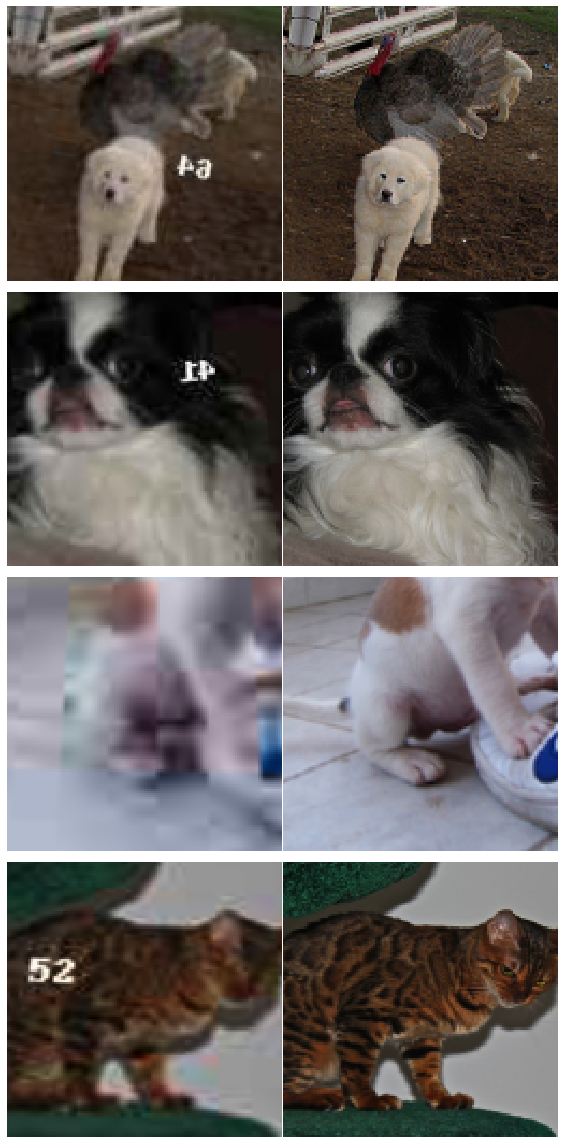

In [0]:
data_gen.show_batch(4)

Our data is just literally the file names from each of those two folders, do some transforms, data bunch, normalize. We'll use ImageNet stats because we're going to use a pre-trained model.

Why are we using a pre-trained model? Because if you're going to get rid of this 46, you need to know what probably was there, and to know what probably was there you need to know what this is a picture of.

In [0]:
wd = 1e-3

In [0]:
y_range = (-3.,3.)

In [0]:
loss_gen = MSELossFlat()

In [0]:
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)

So we created our U-Net with that data, the architecture is ResNet 34.

We're using MSE loss, so in other words what's the mean squared error between the actual pixel value that it should be in the pixel value that we predicted. MSE loss normally expects two vectors so we are using MSELossFlat as we have 2 images.

In [0]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [0]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

We're already down to 0.046 mean squared error on the pixel values which is not bad after ~4 mins.

As we're doing transfer learning by default when you create this, it'll freeze the the pre-trained part. And the pre-trained part of a U-Net is the downsampling part. That's where the ResNet is. Let's unfreeze that and train a little more

In [0]:
learn_gen.unfreeze()

In [0]:
learn_gen.fit_one_cycle(3, slice(1e-6,1e-3))

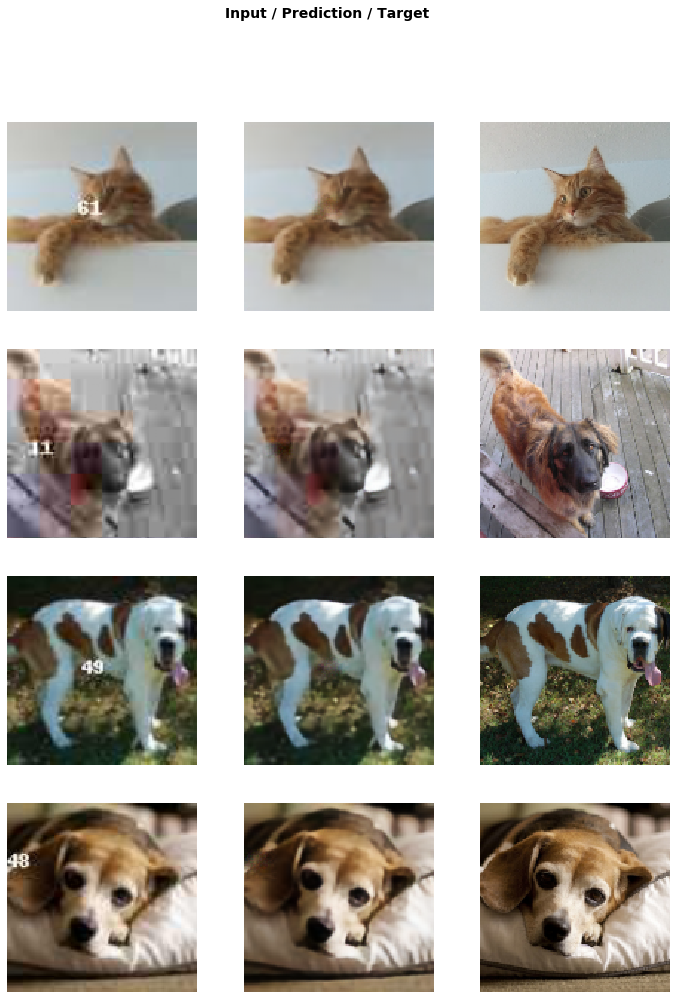

In [0]:
learn_gen.show_results(rows=4)

Look at that!
With 10 minutes of training, we've got something which is basically doing a perfect job of removing numbers. It's certainly not doing a good job of upsampling, but it's definitely doing a nice job. Sometimes when it removes a number, it leaves a little bit of JPEG artifact. But it's certainly doing something pretty useful. So if all we wanted to do was kind of watermark removal, we would be finished.

The reason that we're not making as much progress with that as we'd like is that our loss function doesn't really describe what we want. Because actually, the mean squared error between the pixels of this (middle) and this (right) is actually very small. If you actually think about it, most of the pixels are very nearly the right color. But we're missing the texture of the pillow, and we're missing the eyeballs entirely pretty much. We're missing the texture of the fur. So we want some lost function that does a better job than pixel mean squared error loss of saying like is this a good quality picture of this thing.

There's a fairly general way of answering that question, and it's something called a Generative adversarial network or GAN. A GAN tries to solve this problem by using a loss function which actually calls another model.

![alt text](https://raw.githubusercontent.com/hiromis/notes/master/lesson7/28.png)

We've got our crappy image, and we've already created a generator. It's not a great one, but it's not terrible and that's creating predictions (like the middle picture). We have a high-res image (like the right picture) and we can compare the high-res image to the prediction with pixel MSE.

This is exactly what we are doing

We could also train another model which we would variously call either the discriminator or the critic - they both mean the same thing. We could try and build a binary classification model that takes all the pairs of the generated image and the real high-res image, and learn to classify which is which.It will help generator to generate better images

In [0]:
learn_gen.save('gen-pre2')

## Save generated images

To create classifier we need two folders one with high res images and one with generated images. We already have high res images folder so let's save generated images

In [0]:
learn_gen.load('gen-pre2');

In [0]:
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
# shutil.rmtree(path_gen)

In [0]:
path_gen.mkdir(exist_ok=True)

In [0]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

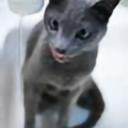

In [0]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

In [0]:
learn_gen=None
gc.collect()

22

Pretrain the critic on crappy vs not crappy.

In [0]:
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

We're going to create our critic. It's just an image item list from folder in the totally usual way, and the classes will be the image_gen and images. We will do a random split because we want to know how well we're doing with the critic to have a validation set. We just label it from folder in the usual way, add some transforms, data bunch, normalized. So we've got a totally standard classifier. Here's what some of it looks like:

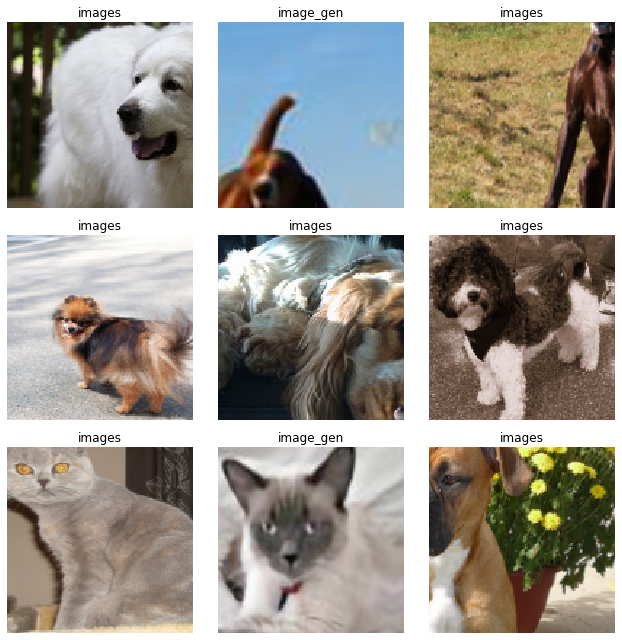

In [0]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

 A GAN critic uses a slightly different way of averaging the different parts of the image when it does the loss, so anytime you're doing a GAN at the moment, you have to wrap your loss function with AdaptiveLoss

We're going to use binary cross entropy as usual. However, we're not going to use a ResNet here. While doing a GAN, we need to be particularly careful that the generator and the critic can't both push in the same direction and increase the weights out of control. 

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

Anyway, if you say gan_critic, fast.ai will give you a binary classifier suitable for GANs

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [0]:
learn_critic.fit_one_cycle(6, 1e-3)

As we can see it's 98% accurate at recognizing that kind of crappy thing from that kind of nice thing.

In [0]:
learn_critic.save('critic-pre2')

## GAN

Now we'll combine those pretrained model in a GAN.

In [0]:
learn_crit=None
learn_gen=None
gc.collect()

13666

In [0]:
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

Now that we have pre-trained the generator and pre-trained the critic, we now need to get it to kind of ping pong between training a little bit of each. The amount of time you spend on each of those things and the learning rates you use is still a little bit on the fuzzy side, so Fast ai provides a GANLearner for you which you just pass in your generator and your critic (which we've just simply loaded here from the ones we just trained) and it will go ahead and when you go learn.fit, it will do that for you - it'll figure out how much time to train generator and then when to switch to training the discriminator/critic and it'll go backward and forward.

In [0]:
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [0]:
learn_gen = create_gen_learner().load('gen-pre2')

To define a GAN Learner, we just have to specify the learner objects for the generator and the critic. The switcher is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss back < 0.5 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predicitions (target 0). 

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [0]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

These weights here (weights_gen=(1.,50.)) is that, what we actually do is we don't only use the critic as the loss function. If we only use the critic as the loss function, the GAN could get very good at creating pictures that look like real pictures, but they actually have nothing to do with the original photo at all. So we actually add together the pixel loss and the critic loss. Those two losses on different scales, so we multiplied the pixel loss by something between about 50 and about 200 - something in that range generally works pretty well.

In [0]:
lr = 1e-4

In [0]:
learn.fit(40,lr)

One of the tough things about GANs is that these loss numbers, they're meaningless. You can't expect them to go down because as the generator gets better, it gets harder for the discriminator (i.e. the critic) and then as the critic gets better, it's harder for the generator. So the numbers should stay about the same.

In [0]:
learn.save('gan-1c')

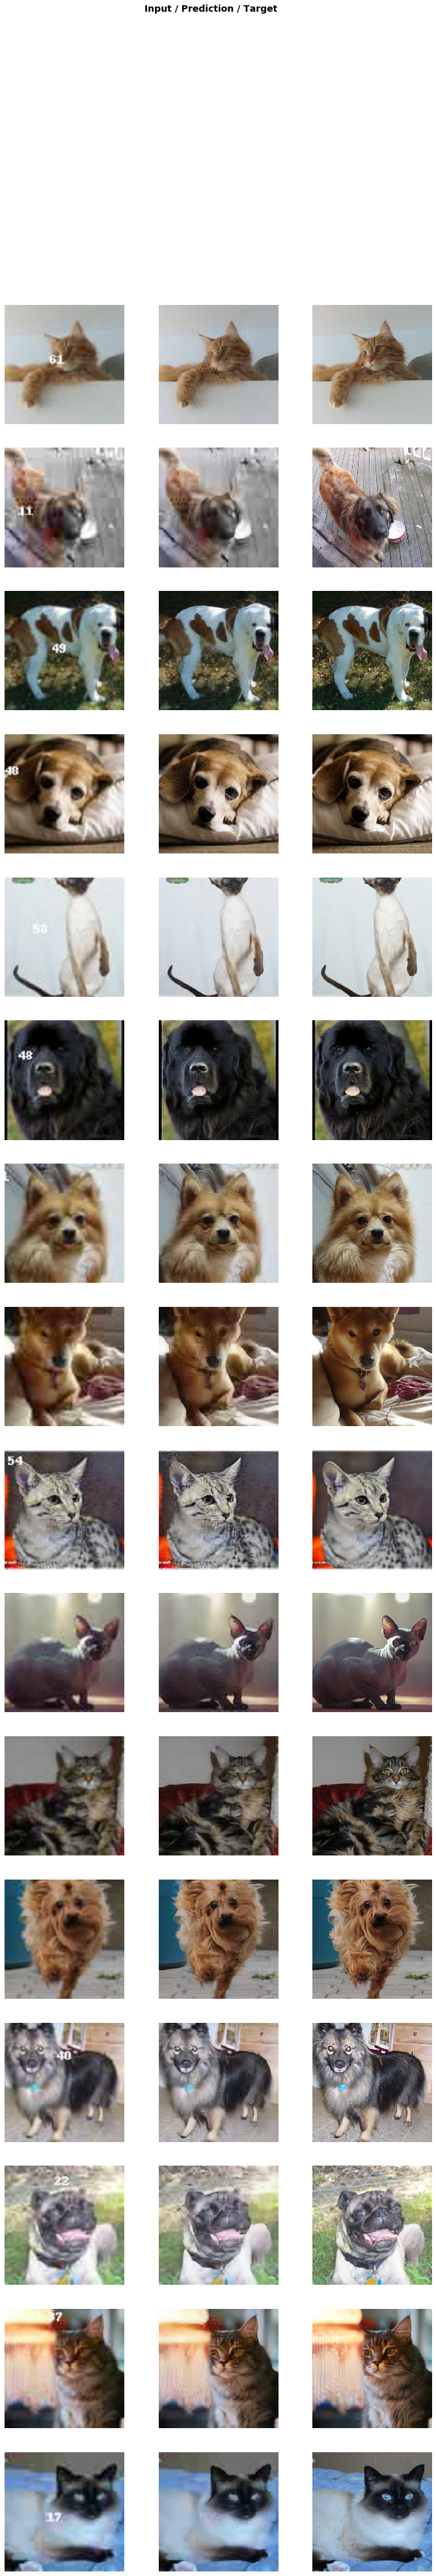

In [0]:
learn.show_results(rows=16)

In [0]:
learn.data=get_data(16,192)

In [0]:
learn.fit(10,lr/2)

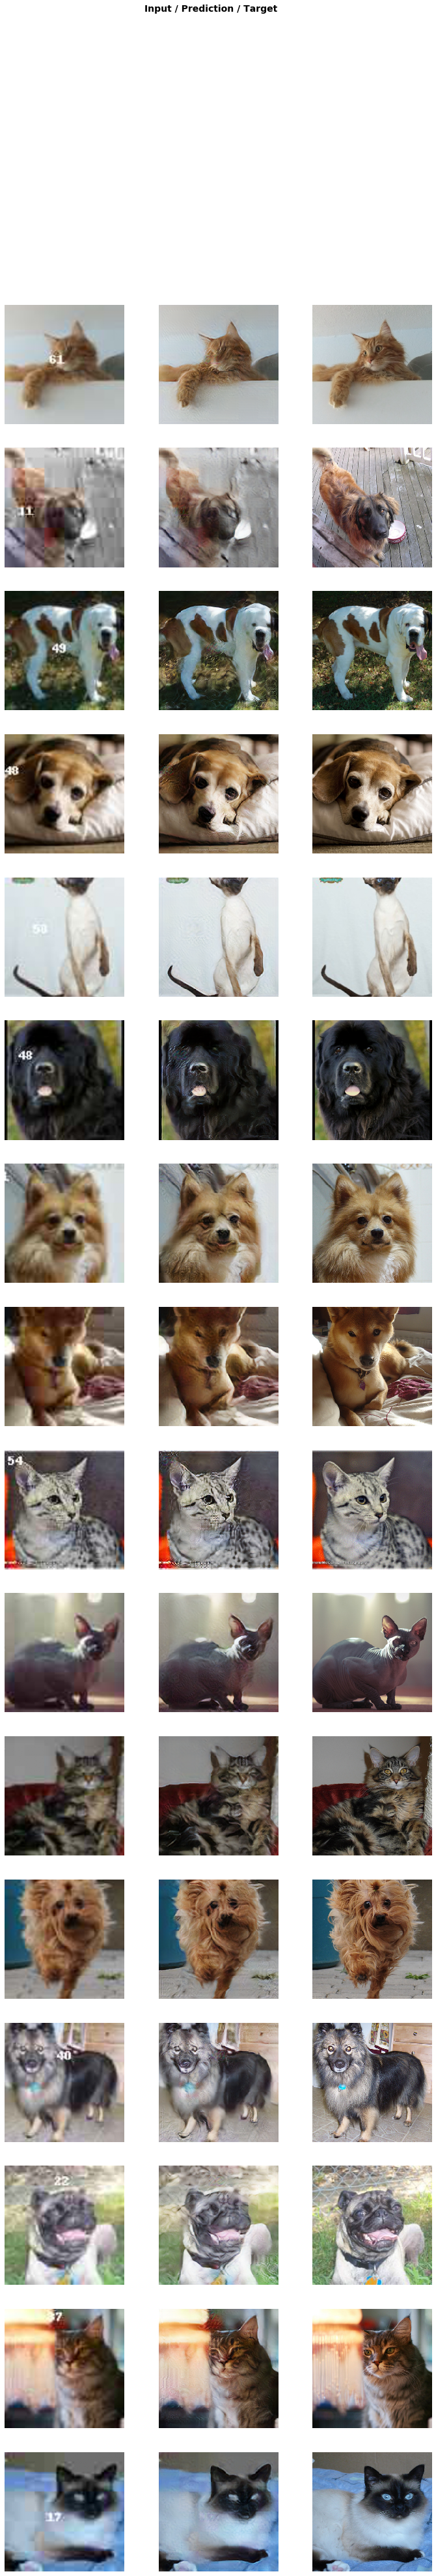

In [0]:
learn.show_results(rows=16)

In [0]:
learn.save('gan-1c')